# Predicción multiclase (SUBE, BAJA, MANTIENE) de la variación diaria de acciones a partir de:

### 1) Cotizaciones históricas de precios

### 2) Análisis de sentimiento diario (agregado por día, por expertos)

Para predecir el comportamiento de cada acción en los próximos 1 a 5 días.



## Paso 1: Cargo data sets obtenidos desde base de datos (Scrapping)

In [11]:
import pandas as pd

# Reemplazá el nombre del archivo por la ruta correcta si no está en el mismo directorio
acciones_df = pd.read_csv("cotizacion_x_empresa.csv")
sentimientos_df = pd.read_csv("view_variacion_x_noticias.csv")
empresas_df = pd.read_csv("empresas.csv")
llm_df = pd.read_csv("notas_x_usuario_openai.csv")
llm_df = llm_df[llm_df['relevante_economia'] == 1].copy()

# Ver las primeras filas para verificar que se cargó correctamente
print(acciones_df.head())
print(sentimientos_df.head())
print(empresas_df.head())

# Ver información básica de los DataFrames (columnas, tipos, nulos)
print(sentimientos_df.info())
print(empresas_df.info())
print(llm_df.info())

# Agrega la columna 'empresa' con un valor predeterminado
acciones_df['nombre'] = 'NNNN'  # Reemplaza 'Valor predeterminado' con el valor que desees
print(acciones_df.info())


   id_cotizacion  id_empresa                fecha  precio_apertura  \
0            658          10  2023-01-02 03:00:00            13.05   
1            659          10  2023-01-03 03:00:00            13.50   
2            660          10  2023-01-04 03:00:00            13.20   
3            661          10  2023-01-05 03:00:00            13.00   
4            662          10  2023-01-06 03:00:00            12.95   

   precio_cierre  precio_max  precio_min  volumen_operado variacion_porcentaje  
0          13.50       13.50       13.05          9563.95                  NAN  
1          13.20       13.50       12.55         38148.80    -2.22222222222222  
2          12.90       13.35       12.80         13887.00    -2.27272727272726  
3          13.15       13.15       12.90         24053.30     1.93798449612403  
4          13.30       13.30       12.80         44834.15     1.14068441064639  
  nombre_empresa     fecha_cotizacion  variacion_total_cotizacion  \
0          AAPLD  2023-0

In [12]:
# Notas po0r usuarios y agrego id_nota
notas_df = pd.read_csv("notas_x_usuario.csv")
notas_df['fecha_publicacion'] = pd.to_datetime(notas_df['fecha_publicacion'], format='mixed')
notas_df['fecha'] = notas_df['fecha_publicacion'].dt.date 



llm_df = llm_df.merge(
    notas_df[['id_nota', 'fecha_publicacion']],
    on='id_nota',
    how='left'
)

print(notas_df.info())
print(llm_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48491 entries, 0 to 48490
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id_nota                         48491 non-null  int64         
 1   contenido                       48412 non-null  object        
 2   fecha_publicacion               48491 non-null  datetime64[ns]
 3   id_usuario                      48491 non-null  object        
 4   cod_tipo_nota                   48491 non-null  int64         
 5   url_nota                        48491 non-null  object        
 6   engagement_total                48491 non-null  int64         
 7   score_analisis_sentimiento_nlp  0 non-null      float64       
 8   sentimiento                     48491 non-null  object        
 9   score_sentimiento               48491 non-null  float64       
 10  fecha                           48491 non-null  object        
dtypes:

## Paso 2: Agrego el nombre de empresa al data frame de cotizaciones históricas.

Esto lo hacemos usando la relación del campo "empresa_id" del data frame "empresa_df".

In [14]:
# Hacemos un merge usando la columna 'id_empresa' que existe en ambos DataFrames
acciones_df = acciones_df.merge(
    empresas_df[['id_empresa', 'nombre']],  # Solo traemos la columna que necesitamos
    on='id_empresa',
    how='left'  # Para mantener todas las filas originales de acciones_df
)


# Verificamos que se haya agregado correctamente
print(acciones_df[['id_empresa', 'nombre']].head())

# merge de sentimientos LLM
llm_df['fecha_publicacion'] = pd.to_datetime(llm_df['fecha_publicacion'])
llm_df['fecha_publicacion'] = llm_df['fecha_publicacion'].dt.date 
sentimientos_df['fecha_cotizacion'] = pd.to_datetime(sentimientos_df['fecha_cotizacion'])
sentimientos_df['fecha_cotizacion'] = sentimientos_df['fecha_cotizacion'].dt.date 


# Elegimos la valoracion_llm más frecuente por día
valoracion_por_fecha = (
    llm_df.groupby('fecha_publicacion')['valoracion_llm']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    .reset_index()
)

sentimientos_df = sentimientos_df.merge(
    valoracion_por_fecha,
    left_on='fecha_cotizacion',
    right_on='fecha_publicacion',
    how='left'
)

# (opcional) eliminar la columna 'fecha_publicacion' duplicada si ya no se necesita
# sentimientos_df.drop(columns='fecha_publicacion', inplace=True)


   id_empresa nombre
0          10  AAPLD
1          10  AAPLD
2          10  AAPLD
3          10  AAPLD
4          10  AAPLD


In [15]:
print(sentimientos_df.tail())

     nombre_empresa fecha_cotizacion  variacion_total_cotizacion  \
5099           XOMD       2025-04-24                       -0.05   
5100           XOMD       2025-04-25                        0.00   
5101           XOMD       2025-04-28                        0.10   
5102           XOMD       2025-04-29                       -0.20   
5103           XOMD       2025-04-30                       -0.05   

      total_noticias_negativas  suma_score_sentimiento_negativas  \
5099                       118                          -62.0434   
5100                       118                          -60.9628   
5101                       100                          -44.8269   
5102                        99                          -44.6587   
5103                        97                          -46.3100   

      total_noticias_positivas  suma_score_sentimiento_positivas  \
5099                        91                           41.9033   
5100                        72                

## Paso 3: Etiquetamos en el data frame de cotizaciones histórcas el target para el modelo.

Creamos la columna de etiqueta (label) con las tres clases (SUBE, BAJA, MANTIENE) de forma muy simple.

In [16]:
# Función que agrega la etiqueta a predecir
def etiquetar(variacion):
    if variacion > 0:
        return "SUBE"
    elif variacion < 0:
        return "NO_SUBE"
    else:
        return "NO_SUBE"

# Antes de aplicar la función etiquetar, asegurate de que los valores en "variacion_porcentaje" sean numéricos.
acciones_df['variacion_porcentaje'] = pd.to_numeric(
    acciones_df['variacion_porcentaje'], errors='coerce'
)

acciones_df['label'] = acciones_df['variacion_porcentaje'].apply(etiquetar)

# Lista de columnas a eliminar
columnas_a_eliminar = ['nombre_x', 'nombre_y']

# Llamás a la función
acciones_df = acciones_df.drop(columns=columnas_a_eliminar)

print(acciones_df.head(200))

     id_cotizacion  id_empresa                fecha  precio_apertura  \
0              658          10  2023-01-02 03:00:00            13.05   
1              659          10  2023-01-03 03:00:00            13.50   
2              660          10  2023-01-04 03:00:00            13.20   
3              661          10  2023-01-05 03:00:00            13.00   
4              662          10  2023-01-06 03:00:00            12.95   
..             ...         ...                  ...              ...   
195            853          10  2023-10-19 03:00:00            18.90   
196            854          10  2023-10-20 03:00:00            18.70   
197            855          10  2023-10-23 03:00:00            19.00   
198            856          10  2023-10-24 03:00:00            17.95   
199            857          10  2023-10-25 03:00:00            18.10   

     precio_cierre  precio_max  precio_min  volumen_operado  \
0            13.50       13.50       13.05          9563.95   
1        

## Paso 4: Merge de datos de acciones y análisis de sentimiento.

Este nuevo data set será el que usaremos para input del modelo.

In [17]:
# Renombrar columnas en sentimientos_df para facilitar el merge
sentimientos_df = sentimientos_df.rename(columns={
    'nombre_empresa': 'nombre',
    'fecha_cotizacion': 'fecha'
})

# Asegurarse de que las fechas estén en formato datetime
acciones_df['fecha'] = pd.to_datetime(acciones_df['fecha'])
acciones_df['fecha'] = acciones_df['fecha'].dt.date 
sentimientos_df['fecha'] = pd.to_datetime(sentimientos_df['fecha'])
sentimientos_df['fecha'] = sentimientos_df['fecha'].dt.date 

# Hacer el merge
analisis_df = acciones_df.merge(
    sentimientos_df,
    on=['nombre', 'fecha'],
    how='left'  # o 'inner' si solo querés mantener las coincidencias
)


# Verificación
print(analisis_df.head())
print(analisis_df.info())


   id_cotizacion  id_empresa       fecha  precio_apertura  precio_cierre  \
0            658          10  2023-01-02            13.05          13.50   
1            659          10  2023-01-03            13.50          13.20   
2            660          10  2023-01-04            13.20          12.90   
3            661          10  2023-01-05            13.00          13.15   
4            662          10  2023-01-06            12.95          13.30   

   precio_max  precio_min  volumen_operado  variacion_porcentaje nombre  \
0       13.50       13.05          9563.95                   NaN  AAPLD   
1       13.50       12.55         38148.80             -2.222222  AAPLD   
2       13.35       12.80         13887.00             -2.272727  AAPLD   
3       13.15       12.90         24053.30              1.937984  AAPLD   
4       13.30       12.80         44834.15              1.140684  AAPLD   

     label  variacion_total_cotizacion  total_noticias_negativas  \
0  NO_SUBE              

## Paso 5: Feature Engineering:

- Variables que vamos a transformar.
- Código para aplicar lag, rolling mean y rolling std
- Relaciones de sentimiento
- Eliminar filas con NaN por lags o rolling


In [18]:
# Asegurarse del tipo datetime
analisis_df['fecha'] = pd.to_datetime(analisis_df['fecha'])

# Ordenar por empresa y fecha
analisis_df = analisis_df.sort_values(by=['id_empresa', 'fecha']).copy()

import numpy as np
from sklearn.linear_model import LinearRegression

# Asegurar que la fecha esté en formato datetime y los datos estén ordenados
analisis_df['fecha'] = pd.to_datetime(analisis_df['fecha'])
analisis_df = analisis_df.sort_values(by=['id_empresa', 'fecha']).copy()

# Función que calcula la pendiente sobre una ventana rolling
def rolling_tendencia_precio(series, window=5):
    X = np.arange(window).reshape(-1, 1)
    lr = LinearRegression()
    slopes = [np.nan] * (window - 1)

    for i in range(window, len(series) + 1):
        y = series.values[i - window:i].reshape(-1, 1)
        lr.fit(X, y)
        slopes.append(lr.coef_[0][0])  # la pendiente
    return pd.Series(slopes, index=series.index)

# Crear la columna vacía para la tendencia
analisis_df['tendencia_precio_5d'] = np.nan

# Calcular tendencia por grupo de empresa
for empresa_id, grupo in analisis_df.groupby('id_empresa'):
    tendencia = rolling_tendencia_precio(grupo['precio_cierre'], window=5)
    analisis_df.loc[grupo.index, 'tendencia_precio_5d'] = tendencia



# ----------------------------------------
# 1. Features derivados de la fecha
# ----------------------------------------
analisis_df['anio'] = analisis_df['fecha'].dt.year
analisis_df['mes'] = analisis_df['fecha'].dt.month
analisis_df['dia'] = analisis_df['fecha'].dt.day
analisis_df['dia_semana'] = analisis_df['fecha'].dt.weekday  # 0 = lunes
analisis_df['es_fin_de_mes'] = analisis_df['fecha'].dt.is_month_end.astype(int)

# ----------------------------------------
# 2. Lags de variables clave (1 día atrás)
# ----------------------------------------
lag_features = [
    'variacion_porcentaje',
    'precio_cierre',
    'volumen_operado',
    'suma_score_sentimiento_positivas',
    'suma_score_sentimiento_negativas',
    'total_noticias_positivas',
    'total_noticias_negativas'
]

for col in lag_features:
    for lag in [1, 2, 3]:
        analisis_df[f'{col}_lag_{lag}'] = analisis_df.groupby('id_empresa')[col].shift(lag)

# ----------------------------------------
# 3. Medias móviles y std (ventanas de 3 y 5 días)
# ----------------------------------------
rolling_features = [
    'variacion_porcentaje',
    'precio_cierre',
    'volumen_operado',
    'suma_score_sentimiento_positivas',
    'suma_score_sentimiento_negativas',
    'total_noticias_positivas',
    'total_noticias_negativas'
]

for col in rolling_features:
    analisis_df[f'{col}_media_3d'] = analisis_df.groupby('id_empresa')[col].transform(lambda x: x.rolling(window=3).mean())
    analisis_df[f'{col}_std_3d'] = analisis_df.groupby('id_empresa')[col].transform(lambda x: x.rolling(window=3).std())
    
    analisis_df[f'{col}_media_5d'] = analisis_df.groupby('id_empresa')[col].transform(lambda x: x.rolling(window=5).mean())
    analisis_df[f'{col}_std_5d'] = analisis_df.groupby('id_empresa')[col].transform(lambda x: x.rolling(window=5).std())

# ----------------------------------------
# 4. Ratios y diferencias
# ----------------------------------------
analisis_df['ratio_sent_positivo_negativo'] = (
    analisis_df['suma_score_sentimiento_positivas'] / 
    (analisis_df['suma_score_sentimiento_negativas'] + 1e-6)
)

analisis_df['diff_score_sentimiento'] = (
    analisis_df['suma_score_sentimiento_positivas'] -
    analisis_df['suma_score_sentimiento_negativas']
)


print(analisis_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5104 entries, 0 to 5100
Data columns (total 75 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   id_cotizacion                              5104 non-null   int64         
 1   id_empresa                                 5104 non-null   int64         
 2   fecha                                      5104 non-null   datetime64[ns]
 3   precio_apertura                            5104 non-null   float64       
 4   precio_cierre                              5104 non-null   float64       
 5   precio_max                                 5104 non-null   float64       
 6   precio_min                                 5104 non-null   float64       
 7   volumen_operado                            5104 non-null   float64       
 8   variacion_porcentaje                       5039 non-null   float64       
 9   nombre                  

## Paso 5b: Generación de csv para fase de modelado final

In [212]:
# Genera csv
analisis_df.to_csv("data_set_integrado_modelo_final.csv", index=False)

## Paso 5c: Generación de label para el futuro.

In [20]:
# Ordenar bien por empresa y fecha
analisis_df = analisis_df.sort_values(by=['id_empresa', 'fecha'])

# Crear columna objetivo futura (desplazar -1 día) y dejar datos > al 31/12/2023
analisis_df['label_t_plus_1'] = analisis_df.groupby('id_empresa')['label'].shift(-1)
analisis_df = analisis_df[analisis_df['fecha'] > pd.to_datetime('2023-12-31')].copy()
# Eliminar filas con NaN en label_t_plus_1 o en tus variables predictoras
analisis_df_model = analisis_df.dropna(subset=['label_t_plus_1'])

# Genera csv
analisis_df_model.to_csv("data_set_integrado_modelo_final_futuro_binario.csv", index=False)

print(analisis_df_model.tail)


<bound method NDFrame.tail of       id_cotizacion  id_empresa      fecha  precio_apertura  precio_cierre  \
243             901          10 2024-01-02            18.90          18.80   
244             902          10 2024-01-03            19.00          18.80   
245             903          10 2024-01-04            18.80          18.95   
246             904          10 2024-01-05            19.00          18.80   
247             905          10 2024-01-08            19.10          19.35   
...             ...         ...        ...              ...            ...   
5062           5720          18 2025-04-23            11.05          11.00   
5071           5729          18 2025-04-24            10.85          10.80   
5078           5736          18 2025-04-25            11.00          11.00   
5085           5743          18 2025-04-28            10.95          11.05   
5093           5751          18 2025-04-29            11.05          10.85   

      precio_max  precio_min  vol

## Paso 7: Separar analisis_df en conjuntos de entrenamiento, validación y test manteniendo el orden temporal.

### Proporción sugerida:

- Entrenamiento: 70%
- Validación: 15%
- Test (evaluación final): 15%

### Consideraciones:

- Vamos a ordenar por id_empresa y fecha.
- Vamos a hacer el split por fecha, no aleatoriamente.
- Vamos a usar label como variable objetivo.

In [21]:
# Volver a ordenar por tiempo
analisis_df_model = analisis_df_model.sort_values(by=['fecha'])

# Elegir columnas predictoras (features)
feature_cols = [
    col for col in analisis_df_model.columns
    if col not in ['label', 'label_t_plus_1', 'fecha', 'nombre', 'valoracion_llm', 'fecha_publicacion']
]

# Dividir en train/val/test por tiempo
train_size = int(len(analisis_df_model) * 0.7)
val_size = int(len(analisis_df_model) * 0.15)

train_data = analisis_df_model.iloc[:train_size]
val_data = analisis_df_model.iloc[train_size:train_size + val_size]
test_data = analisis_df_model.iloc[train_size + val_size:]

# Preparar para AutoGluon
from autogluon.tabular import TabularPredictor

train_df = train_data[feature_cols + ['label_t_plus_1']]
test_df = test_data[feature_cols + ['label_t_plus_1']]



In [71]:
# Instalamos libería Autogluon
# !pip install autogluon

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
INFO: pip is looking at multiple versions of thinc to determine which version is compatible with other requirements. This could take a while.
  Using cached alembic-1.15.2-py3-none-any.whl.metadata (7.3 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
INFO: pip is looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.12.3 requires botocore<1.34.70,>=1.34.41, but you have botocore 1.38.7 which is incompatible.
autoviz 0.1.905 requires xgboost<1.7,>=0.82, but you have xgboost 3.0.0 which is incompatible.
ydata-profiling 4.16.1 requires visions[type_image_path]<0.8.2,>=0.7.5, but you have visions 0.7.4 which is incompatible.


In [22]:
predictor = TabularPredictor(label='label_t_plus_1', problem_type='binary').fit(train_df)


No path specified. Models will be saved in: "AutogluonModels\ag-20250502_232406"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.12.7
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          14
Memory Avail:       0.88 GB / 15.31 GB (5.7%)
Disk Space Avail:   286.52 GB / 475.95 GB (60.2%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions and benchmarks.
	presets='high'        

## Paso 8: Evaluando la performance

In [23]:
performance = predictor.evaluate(test_df)
print(performance)


{'accuracy': 0.482837528604119, 'balanced_accuracy': 0.523712796961936, 'mcc': 0.04931378615173126, 'roc_auc': 0.544069592864082, 'f1': 0.5129310344827587, 'precision': 0.4033898305084746, 'recall': 0.7041420118343196}


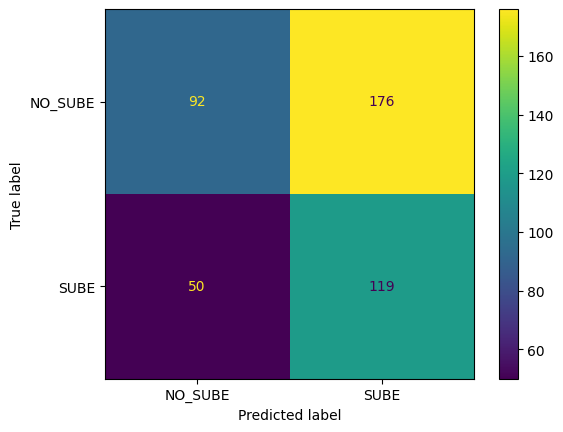

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay

y_true = test_df['label_t_plus_1']
y_pred = predictor.predict(test_df.drop(columns='label_t_plus_1'))

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, labels=predictor.class_labels)


In [25]:
print(analisis_df_model['label_t_plus_1'].value_counts(normalize=True))


label_t_plus_1
NO_SUBE    0.540736
SUBE       0.459264
Name: proportion, dtype: float64


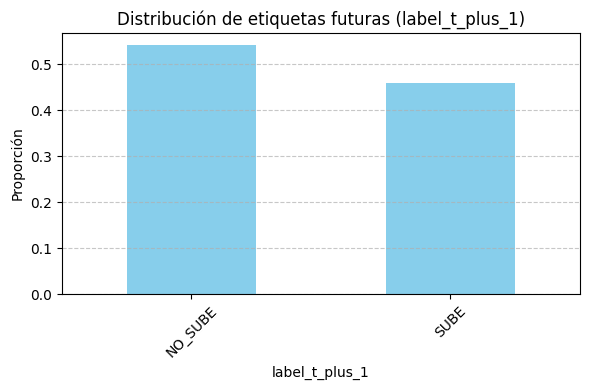

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Distribución de clases en las etiquetas verdaderas
plt.figure(figsize=(6, 4))
analisis_df['label_t_plus_1'].value_counts(normalize=True).plot(kind='bar', color='skyblue')
plt.title('Distribución de etiquetas futuras (label_t_plus_1)')
plt.ylabel('Proporción')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



<Figure size 600x500 with 0 Axes>

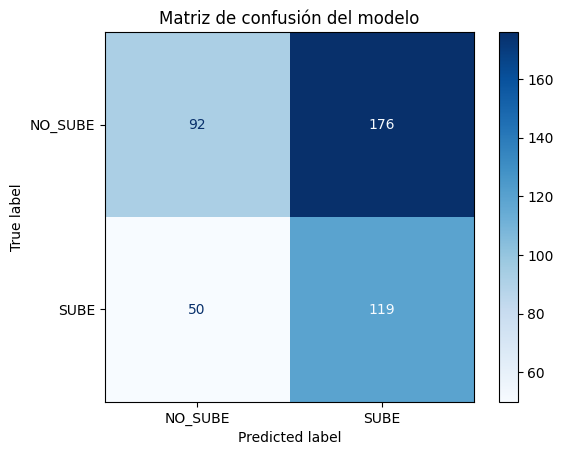

In [27]:
# Confusion matrix entre predicción y valor real
y_true = test_df['label_t_plus_1']
y_pred = predictor.predict(test_df.drop(columns='label_t_plus_1'))

cm = confusion_matrix(y_true, y_pred, labels=predictor.class_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=predictor.class_labels)

plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de confusión del modelo')
plt.grid(False)
plt.show()


In [28]:
from sklearn.metrics import classification_report

# Reporte de métricas por clase
print(classification_report(
    y_true,
    y_pred,
    target_names=predictor.class_labels
))


              precision    recall  f1-score   support

     NO_SUBE       0.65      0.34      0.45       268
        SUBE       0.40      0.70      0.51       169

    accuracy                           0.48       437
   macro avg       0.53      0.52      0.48       437
weighted avg       0.55      0.48      0.47       437



In [29]:
predictor.feature_importance(test_df)

These features in provided data are not utilized by the predictor and will be ignored: ['anio']
Computing feature importance via permutation shuffling for 69 features using 437 rows with 5 shuffle sets...
	56.31s	= Expected runtime (11.26s per shuffle set)
	1.93s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
variacion_porcentaje,0.017849,0.003760,0.000223,5,0.025591,0.010107
volumen_operado_lag_2,0.009153,0.009295,0.046227,5,0.028292,-0.009986
suma_score_sentimiento_negativas_std_3d,0.006407,0.002507,0.002318,5,0.011569,0.001246
precio_cierre_media_3d,0.005950,0.004157,0.016444,5,0.014509,-0.002610
dia,0.005492,0.004745,0.030406,5,0.015262,-0.004278
...,...,...,...,...,...,...
variacion_porcentaje_std_3d,-0.009611,0.006553,0.984745,5,0.003881,-0.023103
variacion_porcentaje_media_5d,-0.010069,0.024572,0.794316,5,0.040525,-0.060662
precio_cierre_lag_3,-0.010984,0.002984,0.999406,5,-0.004841,-0.017127
variacion_porcentaje_lag_1,-0.012815,0.006183,0.995113,5,-0.000084,-0.025545


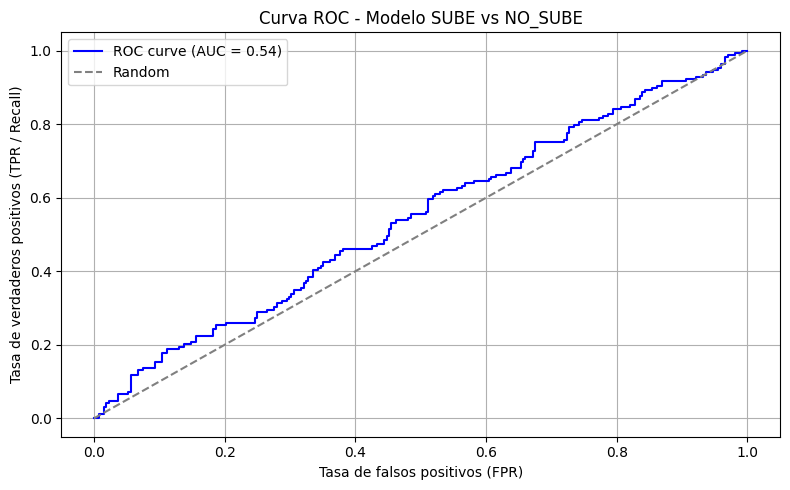

In [38]:
#Curva ROC
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Convertir etiquetas a binario: 1 = SUBE, 0 = NO_SUBE
y_true = (test_df['label_t_plus_1'] == 'SUBE').astype(int)

# Obtener las probabilidades para la clase SUBE
y_scores = predictor.predict_proba(test_df.drop(columns='label_t_plus_1'))['SUBE']

# Calcular curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)

# Graficar
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('Tasa de falsos positivos (FPR)')
plt.ylabel('Tasa de verdaderos positivos (TPR / Recall)')
plt.title('Curva ROC - Modelo SUBE vs NO_SUBE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




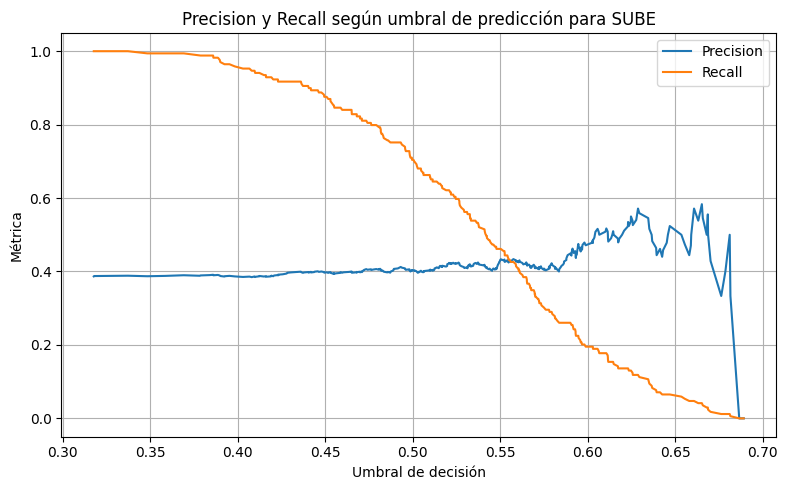

In [40]:
# Probar diferentes umbrales
from sklearn.metrics import precision_recall_curve

# Probabilidades para clase SUBE
y_true = (test_df['label_t_plus_1'] == 'SUBE').astype(int)
y_scores = predictor.predict_proba(test_df.drop(columns='label_t_plus_1'))['SUBE']

# Calcular precisión y recall para distintos umbrales
precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)

# Graficar
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.xlabel('Umbral de decisión')
plt.ylabel('Métrica')
plt.title('Precision y Recall según umbral de predicción para SUBE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


📋 Reporte de clasificación con umbral = 0.52
              precision    recall  f1-score   support

     NO_SUBE       0.66      0.46      0.54       268
        SUBE       0.42      0.62      0.50       169

    accuracy                           0.52       437
   macro avg       0.54      0.54      0.52       437
weighted avg       0.57      0.52      0.53       437



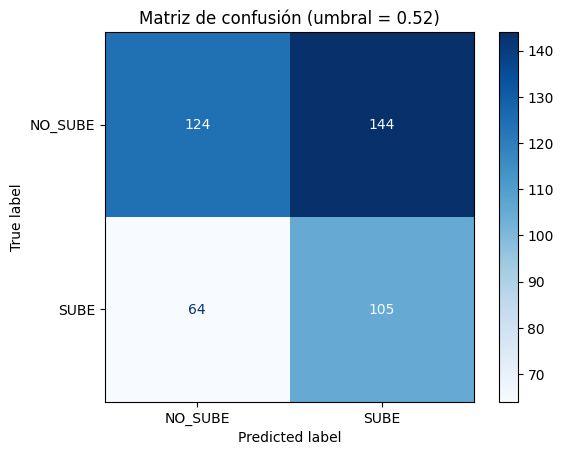

In [43]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Aplicar umbral personalizado
umbral_optimo = 0.52
y_pred_custom = (y_scores >= umbral_optimo).astype(int)

# Evaluar métricas
print("📋 Reporte de clasificación con umbral =", umbral_optimo)
print(classification_report(y_true, y_pred_custom, target_names=["NO_SUBE", "SUBE"]))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred_custom)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NO_SUBE", "SUBE"])
disp.plot(cmap='Blues')
plt.title(f"Matriz de confusión (umbral = {umbral_optimo})")
plt.grid(False)
plt.show()


In [51]:
# Copia segura del DataFrame de entrenamiento
train_df = train_df.copy()
test_df = test_df.copy()

# Crear columna binaria (1 = SUBE, 0 = NO_SUBE)
train_df['label_binaria'] = (train_df['label_t_plus_1'] == 'SUBE').astype(int)
test_df['label_binaria'] = (test_df['label_t_plus_1'] == 'SUBE').astype(int)


In [52]:

# Separar por clase
df_sube = train_df[train_df['label_binaria'] == 1]
df_no_sube = train_df[train_df['label_binaria'] == 0]

# Aumentar la clase minoritaria hasta igualar la mayoría
df_sube_upsampled = df_sube.sample(n=len(df_no_sube), replace=True, random_state=42)

# Combinar y mezclar
train_balanced = pd.concat([df_no_sube, df_sube_upsampled]).sample(frac=1, random_state=42).reset_index(drop=True)


In [53]:
from autogluon.tabular import TabularPredictor

# Definir columnas
feature_cols = [col for col in train_balanced.columns if col not in ['label_binaria', 'label_t_plus_1']]

# Entrenar
predictor_balanced = TabularPredictor(
    label='label_binaria',
    problem_type='binary'
).fit(
    train_data=train_balanced[feature_cols + ['label_binaria']],
    verbosity=2
)


No path specified. Models will be saved in: "AutogluonModels\ag-20250503_000959"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.12.7
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          14
Memory Avail:       2.15 GB / 15.31 GB (14.0%)
Disk Space Avail:   286.44 GB / 475.95 GB (60.2%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions and benchmarks.
	presets='high'       

📋 Reporte de clasificación con umbral = 0.47
              precision    recall  f1-score   support

     NO_SUBE       0.61      0.54      0.58       268
        SUBE       0.38      0.45      0.41       169

    accuracy                           0.51       437
   macro avg       0.50      0.50      0.50       437
weighted avg       0.52      0.51      0.51       437



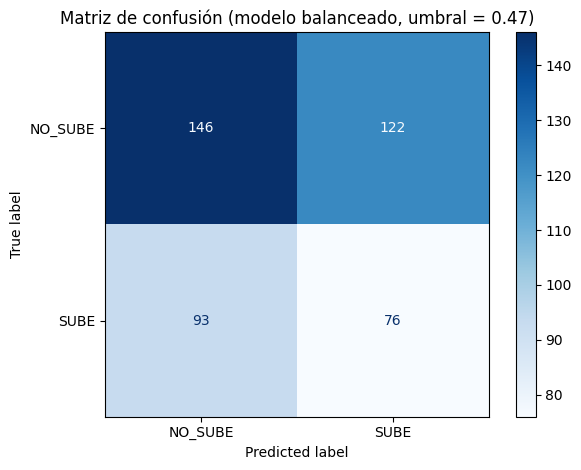

In [64]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Asegurar que las columnas de features estén en test_df
feature_cols = [
    col for col in train_balanced.columns
    if col not in ['label_binaria', 'label_t_plus_1', 'sample_weight']
    and col in test_df.columns  # solo columnas disponibles
]

# Obtener probabilidades para la clase 1 (SUBE)
y_true = test_df['label_binaria']
y_scores = predictor_balanced.predict_proba(test_df[feature_cols])[1]

# Aplicar umbral personalizado
umbral_optimo = 0.47
y_pred_custom = (y_scores >= umbral_optimo).astype(int)

# Mostrar reporte de métricas
print(f"📋 Reporte de clasificación con umbral = {umbral_optimo}")
print(classification_report(y_true, y_pred_custom, target_names=['NO_SUBE', 'SUBE']))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred_custom)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NO_SUBE', 'SUBE'])
disp.plot(cmap='Blues')
plt.title(f"Matriz de confusión (modelo balanceado, umbral = {umbral_optimo})")
plt.grid(False)
plt.tight_layout()
plt.show()


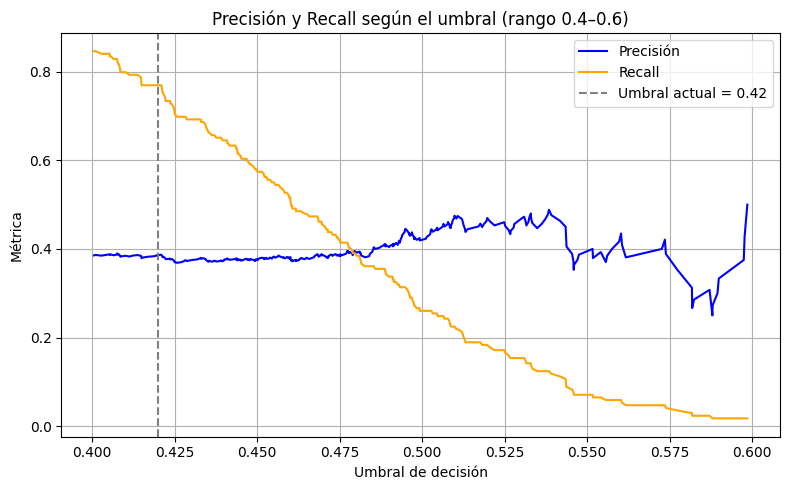

In [65]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Calcular métricas para varios umbrales
precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)

# Recortamos para ver mejor la región entre 0.4 y 0.6
mask = (thresholds >= 0.4) & (thresholds <= 0.6)

# Gráfico
plt.figure(figsize=(8, 5))
plt.plot(thresholds[mask], precisions[:-1][mask], label='Precisión', color='blue')
plt.plot(thresholds[mask], recalls[:-1][mask], label='Recall', color='orange')
plt.axvline(0.42, color='gray', linestyle='--', label='Umbral actual = 0.42')
plt.xlabel("Umbral de decisión")
plt.ylabel("Métrica")
plt.title("Precisión y Recall según el umbral (rango 0.4–0.6)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [68]:
# Obtener importancias de features
importance_df = predictor_balanced.feature_importance(test_df)



These features in provided data are not utilized by the predictor and will be ignored: ['anio', 'label_t_plus_1']
Computing feature importance via permutation shuffling for 69 features using 437 rows with 5 shuffle sets...
	96.25s	= Expected runtime (19.25s per shuffle set)
	3.6s	= Actual runtime (Completed 5 of 5 shuffle sets)


C:\Users\FSONZOGNI\AppData\Local\Temp\ipykernel_92\1559764699.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y=top_features.index, data=top_features, palette='viridis')


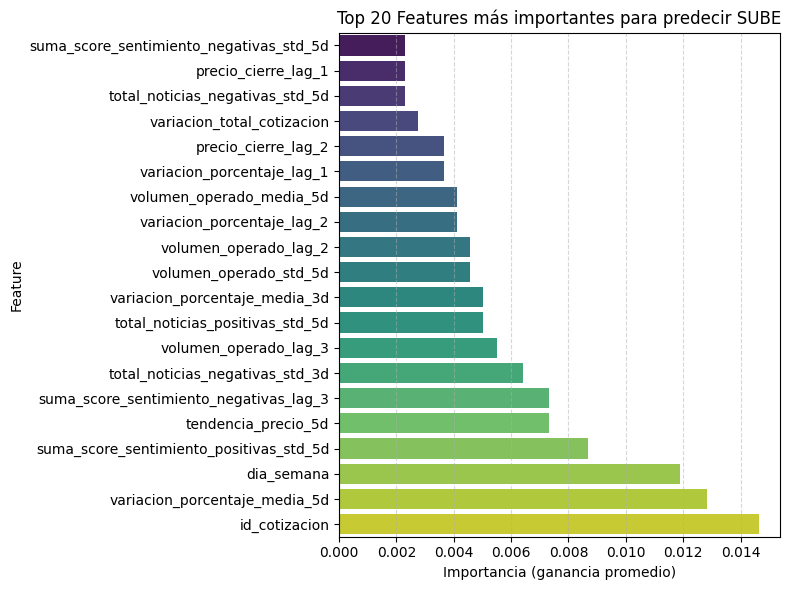

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

# Top 20 variables más importantes
top_n = 20
top_features = importance_df.head(top_n).sort_values(by='importance', ascending=True)

plt.figure(figsize=(8, 6))
sns.barplot(x='importance', y=top_features.index, data=top_features, palette='viridis')
plt.title(f'Top {top_n} Features más importantes para predecir SUBE')
plt.xlabel('Importancia (ganancia promedio)')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [70]:
from autogluon.tabular import TabularPredictor

predictor_specialized = TabularPredictor(
    label='label_binaria',
    problem_type='binary'
).fit(
    train_data=train_balanced[feature_cols + ['label_binaria']],
    hyperparameters={
        'GBM': {},   # LightGBM
        'CAT': {},   # CatBoost
        'XGB': {},   # XGBoost
    },
    verbosity=2
)


No path specified. Models will be saved in: "AutogluonModels\ag-20250503_003900"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.12.7
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          14
Memory Avail:       2.44 GB / 15.31 GB (16.0%)
Disk Space Avail:   286.37 GB / 475.95 GB (60.2%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions and benchmarks.
	presets='high'       

In [71]:
predictor_tuned = TabularPredictor(
    label='label_binaria',
    problem_type='binary'
).fit(
    train_data=train_balanced[feature_cols + ['label_binaria']],
    hyperparameter_tune_kwargs='auto',  # activa búsqueda inteligente
    time_limit=1800,  # por ejemplo, 30 minutos
    verbosity=2
)


No model was trained during hyperparameter tuning NeuralNetTorch... Skipping this model.
Fitting model: LightGBMLarge ... Training model for up to 124.61s of the 1016.17s of remaining time.
	0.7801	 = Validation score   (accuracy)
	3.28s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.00s of the 1003.25s of remaining time.
	Ensemble Weights: {'XGBoost\T3': 0.857, 'CatBoost\T3': 0.143}
	0.7967	 = Validation score   (accuracy)
	0.07s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 796.87s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 32355.7 rows/s (423 batch size)
Disabling decision threshold calibration for metric `accuracy` due to having fewer than 10000 rows of validation data for calibration, to avoid overfitting (423 rows).
	`accuracy` is generally not improved through threshold calibration. Force calibration via specifying `calibrate_decisio


📊 Evaluación: Modelo Base (umbral = 0.42)
              precision    recall  f1-score   support

     NO_SUBE       0.61      0.23      0.34       268
        SUBE       0.39      0.77      0.51       169

    accuracy                           0.44       437
   macro avg       0.50      0.50      0.43       437
weighted avg       0.53      0.44      0.41       437



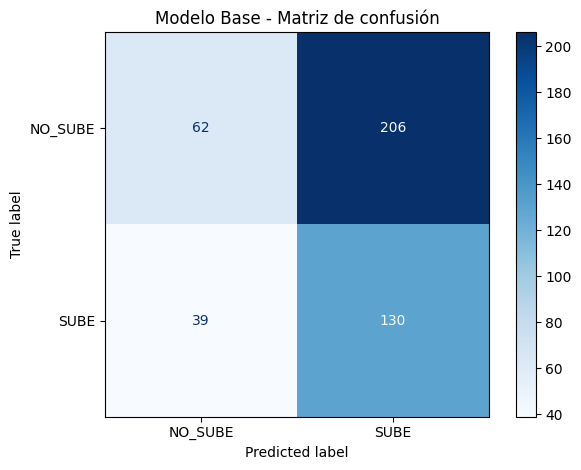


📊 Evaluación: Modelo Especializado (GBM/CAT/XGB) (umbral = 0.42)
              precision    recall  f1-score   support

     NO_SUBE       0.60      0.34      0.43       268
        SUBE       0.38      0.64      0.48       169

    accuracy                           0.46       437
   macro avg       0.49      0.49      0.45       437
weighted avg       0.51      0.46      0.45       437



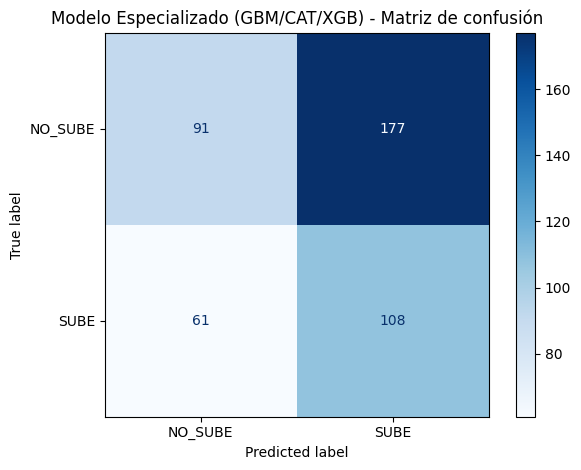


📊 Evaluación: Modelo Tuned (AutoML) (umbral = 0.42)
              precision    recall  f1-score   support

     NO_SUBE       0.65      0.34      0.45       268
        SUBE       0.41      0.72      0.52       169

    accuracy                           0.49       437
   macro avg       0.53      0.53      0.48       437
weighted avg       0.56      0.49      0.47       437



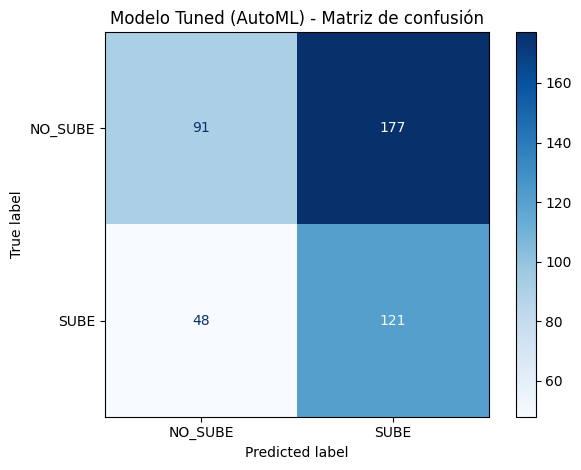

In [72]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def evaluar_modelo(nombre, predictor, X_test, y_true, umbral=0.42):
    print(f"\n📊 Evaluación: {nombre} (umbral = {umbral})")
    y_scores = predictor.predict_proba(X_test)[1]  # Probabilidad para clase SUBE
    y_pred = (y_scores >= umbral).astype(int)

    print(classification_report(y_true, y_pred, target_names=["NO_SUBE", "SUBE"]))

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NO_SUBE', 'SUBE'])
    disp.plot(cmap='Blues')
    plt.title(f'{nombre} - Matriz de confusión')
    plt.grid(False)
    plt.tight_layout()
    plt.show()

# Variables necesarias
X_test = test_df[feature_cols]
y_true = test_df['label_binaria']

# Ejecutar evaluación para cada predictor que hayas entrenado
evaluar_modelo("Modelo Base", predictor_balanced, X_test, y_true, umbral=0.42)
evaluar_modelo("Modelo Especializado (GBM/CAT/XGB)", predictor_specialized, X_test, y_true, umbral=0.42)
evaluar_modelo("Modelo Tuned (AutoML)", predictor_tuned, X_test, y_true, umbral=0.42)


In [73]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import pandas as pd

def obtener_metricas(nombre, predictor, X_test, y_true, umbral=0.42):
    y_scores = predictor.predict_proba(X_test)[1]
    y_pred = (y_scores >= umbral).astype(int)

    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=[1], average='binary')

    return {
        'Modelo': nombre,
        'Accuracy': round(acc, 3),
        'Precision_SUBE': round(precision, 3),
        'Recall_SUBE': round(recall, 3),
        'F1_SUBE': round(f1, 3)
    }

# Recopilar métricas de cada modelo
resumen = pd.DataFrame([
    obtener_metricas("Modelo Base", predictor_balanced, X_test, y_true, umbral=0.42),
    obtener_metricas("Especializado (GBM/CAT/XGB)", predictor_specialized, X_test, y_true, umbral=0.42),
    obtener_metricas("Tuned (AutoML)", predictor_tuned, X_test, y_true, umbral=0.42)
])

# Mostrar
print("📊 Comparación de modelos (Clase: SUBE):")
display(resumen)


📊 Comparación de modelos (Clase: SUBE):


,Modelo,Accuracy,Precision_SUBE,Recall_SUBE,F1_SUBE
0,Modelo Base,0.439,0.387,0.769,0.515
1,Especializado (GBM/CAT/XGB),0.455,0.379,0.639,0.476
2,Tuned (AutoML),0.485,0.406,0.716,0.518
